# Vertical Coord Transforms

I need to figure out how to take a ds_gridded with dimensions `density`, `lon`, `lat` and transform it to have dimensions `av isopycnal depth`, `lon`, `lat`. I've done this before for data with dimensions `density`, `N_PROF`. I don't think this will be very difficult?? Hoping I just have to 
1. flatten the dataset into having dimensions `density`, `N_PROF`
2. perform calculations with established functions
3. reshape the dataset back into the original dimensions of `density`, `lon`, `lat`

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from xgcm import Grid

In [3]:
ds_x = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [4]:
section = ds_x.where((ds_x.LATITUDE < -45) & (ds_x.LATITUDE > -50),drop=True).where((ds_x.LONGITUDE < 30) & (ds_x.LONGITUDE > 25),drop=True).sortby('LATITUDE')

In [42]:
section = section.sortby('N_PROF')

In [43]:
#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_x = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [44]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [130]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [131]:
section_rho = get_ds_rho(section_x, section_x.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','SPICE','PRES','PRES_INTERPOLATED'])

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES


/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRES_INTERPOLATED
Completed PRES_INTERPOLATED
Completed merge


In [59]:
def func_var_int_pmean(ds, var, Pmean_smooth):
    Pmean_grid = np.linspace(0, 2000, 1001)
    
    ds_nonan = ds[var].where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    
    # Extract the latitude value for the current profile
    latitude_val = ds.LATITUDE.values
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values, extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)

    else:
        ds_on_Pmean = np.nan * Pmean_grid
    
    # Return a DataArray with the Pmean and LATITUDE coordinates
    return xr.DataArray(ds_on_Pmean.reshape((-1, 1)),
                        dims=['Pmean', 'N_PROF'],
                        coords={'Pmean': Pmean_grid, 'N_PROF': [ds.N_PROF.values], 'LATITUDE': ('N_PROF', [latitude_val])}).rename(var)

In [114]:
# List to store profiles that cause the error
problem_profiles = []

# Initial setup (placeholders for your actual data)
# section_rho = xr.Dataset(...)
Pmean_smooth = section_rho.PRES.mean('N_PROF').rolling(rho_grid=50, center=True).mean()

# Interpolate to iso
N_PROF_ind = 0
CT_on_Pmean = func_var_int_pmean(section_rho.isel(N_PROF=N_PROF_ind), 'CT', Pmean_smooth)

for N_PROF_ind in range(1, len(section_rho.N_PROF)):
    if np.mod(N_PROF_ind, 50) == 0:
        print(f"Processing profile: {N_PROF_ind}")

    try:
        new_data = func_var_int_pmean(section_rho.isel(N_PROF=N_PROF_ind), 'CT', Pmean_smooth)
        # Ensure new_data is a DataArray before concatenating
        if isinstance(new_data, xr.DataArray):
            CT_on_Pmean = xr.concat([CT_on_Pmean, new_data], dim='N_PROF')
        else:
            # This case should ideally not be reached with the corrected func_var_int_pmean
            print(f"Warning: Unexpected data type returned for profile {N_PROF_ind}.")
            problem_profiles.append(N_PROF_ind)

    except ValueError as e:
        if "`x` must be strictly increasing sequence" in str(e):
            print(f"Skipping profile {N_PROF_ind} due to interpolation error (x not strictly increasing).")
            problem_profiles.append(N_PROF_ind)
            # If func_var_int_pmean returns NaNs correctly, we don't need to explicitly add a NaN DataArray here.
            # The corrected function handles this.
        else:
            print(f"An unexpected ValueError occurred for profile {N_PROF_ind}: {e}")
            problem_profiles.append(N_PROF_ind)
            # Re-raise other unexpected ValueErrors if you want to stop execution
            # raise

# Print all problem profiles at the end
print("\n--- Summary ---")
print("Profiles that encountered interpolation errors or other issues:")
if problem_profiles:
    print(problem_profiles)
else:
    print("No problematic profiles found.")

Processing profile: 50
Processing profile: 100
Processing profile: 150
Skipping profile 199 due to interpolation error (x not strictly increasing).
Processing profile: 200
Skipping profile 200 due to interpolation error (x not strictly increasing).
Skipping profile 217 due to interpolation error (x not strictly increasing).
Processing profile: 250
Skipping profile 251 due to interpolation error (x not strictly increasing).
Skipping profile 259 due to interpolation error (x not strictly increasing).
Processing profile: 300
Skipping profile 300 due to interpolation error (x not strictly increasing).

--- Summary ---
Profiles that encountered interpolation errors or other issues:
[199, 200, 217, 251, 259, 300]


In [115]:
CT_on_Pmean

<xarray.DataArray 'CT' (Pmean: 1001, N_PROF: 300)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * Pmean     (Pmean) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * N_PROF    (N_PROF) int64 2kB 784739 784410 784490 ... 784646 785029 784448
    LATITUDE  (N_PROF) float64 2kB -49.95 -49.9 -49.87 ... -45.04 -45.02 -45.0

Text(0.5, 1.0, 'CT on av isopycnal depth')

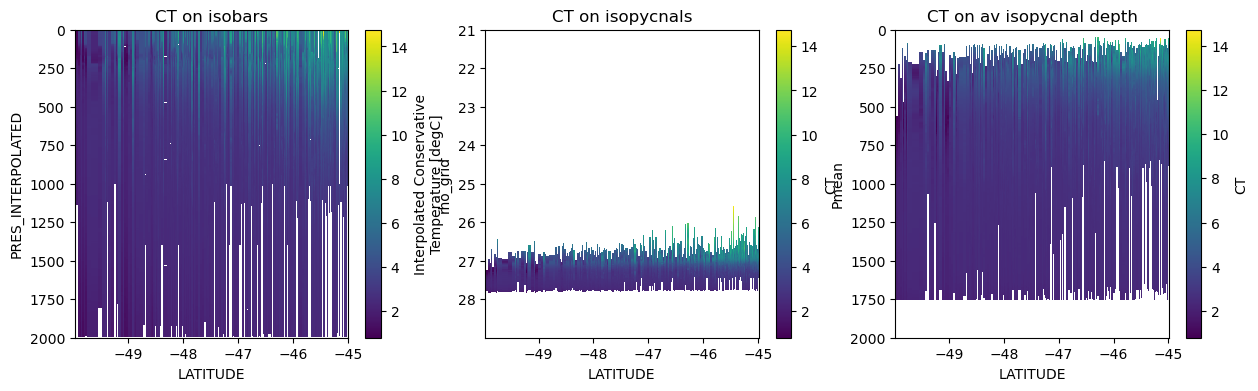

In [116]:
plt.figure(figsize=(15,4))

plt.subplot(131)
section_x.CT.sortby('LATITUDE').plot(x='LATITUDE',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(132)
section_rho.CT.sortby('LATITUDE').plot(x='LATITUDE',y='rho_grid')
plt.gca().invert_yaxis()
plt.title('CT on isopycnals')

plt.subplot(133)
CT_on_Pmean.sortby('LATITUDE').plot(x='LATITUDE',y='Pmean')
plt.gca().invert_yaxis()
plt.title('CT on av isopycnal depth')

Text(0.5, 1.0, '(CT on isobars) - (CT on av isopycnal depth)')

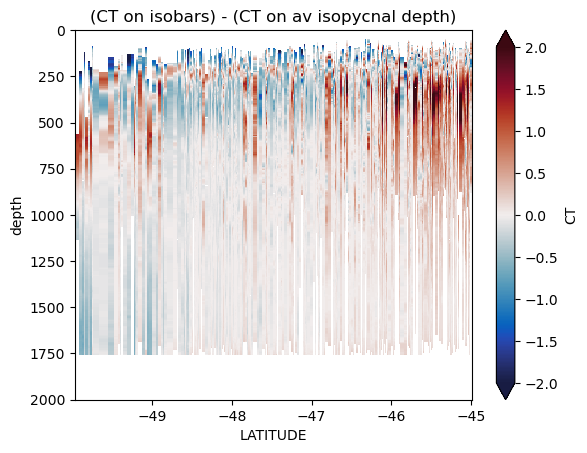

In [128]:
(section_x.CT.rename({'PRES_INTERPOLATED':'depth'}) - CT_on_Pmean.rename({'Pmean':'depth'})).plot(x='LATITUDE', vmin=-2, vmax=2, cmap=cmo.balance)
plt.gca().invert_yaxis()
plt.title('(CT on isobars) - (CT on av isopycnal depth)')

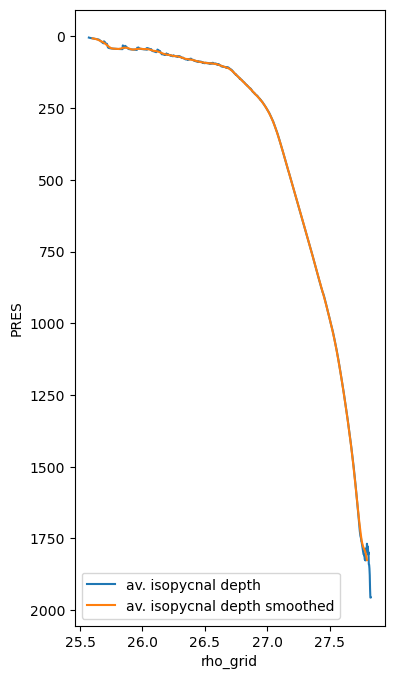

In [117]:
plt.figure(figsize=(4,8))

section_rho.PRES.mean('N_PROF').plot(label='av. isopycnal depth')
section_rho.PRES.mean('N_PROF').rolling(rho_grid=25, center=True).mean().plot(label='av. isopycnal depth smoothed')
plt.gca().invert_yaxis()
plt.legend()

Outstanding questions:
- Why does Pmean_smooth cut off more data points at the bottom than the top? _wondering if this is because it's cutting values off based on density, so cutting off the same number of density values is going to look like more in the deep ocean, because they change slower?_
- Everything else looks about correct, right?

# My attempt to rewrite/simplify

The above code is confusing. This is going to be my attempt at rewritting it while maintaining good functionality.

In [188]:
def interp_to_pmean(var_profile, pmean_smooth, pmean_grid):

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        # The ValueError is raised here if pmean_nonan is not strictly increasing.
        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        # Catch the error for this specific profile and return NaNs
        print(f"ValueError")
        return np.full_like(pmean_grid, np.nan)

In [189]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50):
    
    xrs = []
    pmean_size = pmean_grid.size
    pmean_smooth = ds_rho.PRES.mean('N_PROF').rolling(rho_grid=roll, center=True).mean()
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], pmean_smooth,
                                   input_core_dims=[['rho_grid'], ['rho_grid']],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF','pmean_grid'],
            coords={'pmean_grid': pmean_grid, 'N_PROF': ds_rho.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(LATITUDE  = ('N_PROF', ds_rho.LATITUDE.data))
    ds_pmean = ds_pmean.assign_coords(LONGITUDE = ('N_PROF', ds_rho.LONGITUDE.data))
    ds_pmean = ds_pmean.assign_coords(TIME      = ('N_PROF', ds_rho.TIME.data))
    
    return ds_pmean

In [190]:
testing = get_ds_pmean(section_rho, np.linspace(0, 2000, 1001), ['CT','SA','SIG0','SPICE','PRES'])

ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for CT
Completed CT
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for SA
Completed SA
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for SIG0
Completed SIG0
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for SPICE
Completed SPICE
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
Completed comp for PRES
Completed PRES
Completed merge


Text(0.5, 1.0, 'my function')

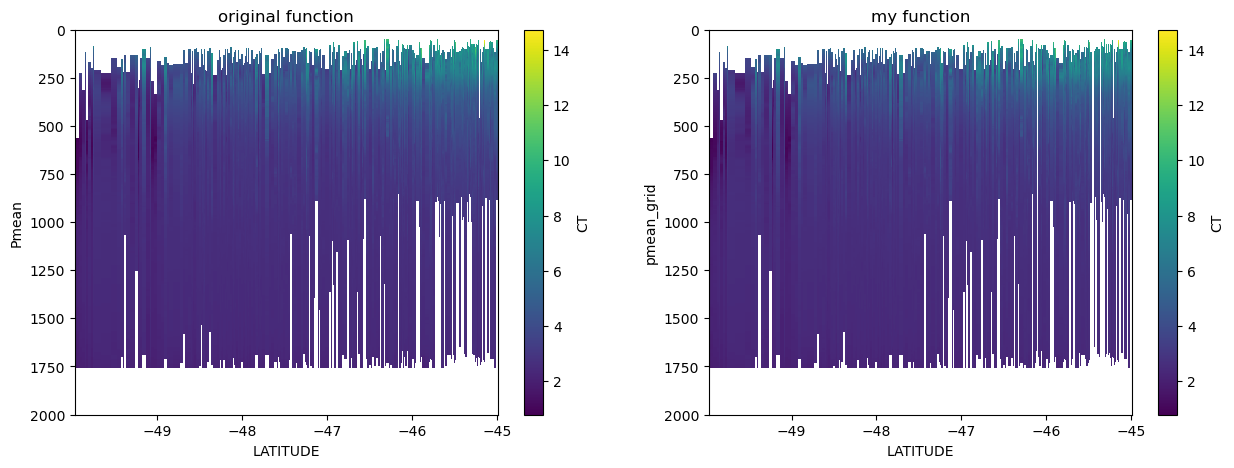

In [191]:
plt.figure(figsize=(15,5))

plt.subplot(121)
CT_on_Pmean.sortby('LATITUDE').plot(x='LATITUDE',y='Pmean')
plt.gca().invert_yaxis()
plt.title('original function')

plt.subplot(122)
testing.CT.sortby('LATITUDE').plot(x='LATITUDE',y='pmean_grid')
plt.gca().invert_yaxis()
plt.title('my function')